In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, levene, f_oneway, kruskal

import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

n = 200

# Вспомогательные списки
names = ['Alice', 'Bob', 'Charlie', 'David', 'Eva', 'Frank', 'Grace', 'Hannah', 'Ivan', 'Julia']
genders = ['Male', 'Female']
countries = ['USA', 'Germany', 'France', 'Canada', 'UK']
cities = ['New York', 'Berlin', 'Paris', 'Toronto', 'London', None]
interests_pool = ['fitness', 'reading', 'travel', 'gaming', 'music', 'art', 'sports', 'tech']

# Генерация датафрейма
df_check = pd.DataFrame({
    'user_id': range(1, n + 1),
    'name': np.random.choice(names, size=n),
    'age': np.random.randint(18, 65, size=n),
    'gender': np.random.choice(genders, size=n),
    'country': np.random.choice(countries, size=n),
    'signup_date': [datetime.today() - timedelta(days=np.random.randint(0, 1000)) for _ in range(n)],
    'last_active_date': [datetime.today() - timedelta(days=np.random.randint(0, 365)) for _ in range(n)],
    'is_premium': np.random.choice([True, False], size=n),
    'income_usd': np.round(np.random.normal(3000, 1000, n), 2),
    'score': np.round(np.random.uniform(0, 100, n), 2),
    'height_cm': np.round(np.random.normal(170, 10, n), 1),
    'city': np.random.choice(cities, size=n),
    'interests': [', '.join(np.random.choice(interests_pool, size=np.random.randint(1, 4), replace=False)) for _ in range(n)]
})

# Добавим пропуски
for i in np.random.choice(df_check.index, size=15, replace=False):
    df_check.at[i, 'income_usd'] = np.nan
for i in np.random.choice(df_check.index, size=10, replace=False):
    df_check.at[i, 'city'] = np.nan

df_check.head()


,user_id,name,age,gender,country,signup_date,last_active_date,is_premium,income_usd,score,height_cm,city,interests
0,1,Grace,39,Male,USA,2024-04-29 19:30:01.419908,2025-02-23 19:30:01.421691,True,3013.00,52.13,183.8,New York,"art, gaming, fitness"
1,2,David,28,Female,France,2023-09-19 19:30:01.419948,2025-05-29 19:30:01.421725,False,3061.57,86.82,177.6,Berlin,"sports, art"
2,3,Hannah,33,Male,Canada,2023-04-29 19:30:01.419961,2024-12-06 19:30:01.421736,False,1306.73,24.53,170.3,Paris,"art, reading, sports"
3,4,Eva,50,Male,USA,2024-08-05 19:30:01.419972,2024-08-26 19:30:01.421744,True,2099.47,15.73,185.8,London,"travel, reading, sports"
4,5,Grace,26,Female,Canada,2022-11-28 19:30:01.419982,2024-07-19 19:30:01.421750,False,3230.94,16.04,179.5,NaN,"fitness, art"


# 🧪 Задания для проверки

- 1. Обзор данных
Посчитай, сколько всего строк и столбцов в датафрейме.

Проверь наличие пропущенных значений.

Выведи долю премиум-пользователей.

- 2. Фильтрация и сортировка
Отфильтруй пользователей из Франции старше 30 лет и отсортируй их по доходу по убыванию.

Выведи топ-5 пользователей с самым высоким баллом (score) среди женщин.

- 3. Работа с датами
Добавь столбец days_since_signup — количество дней с момента регистрации.

Найди пользователя с самой длительной неактивностью (разница между signup_date и last_active_date).

- 4. Работа с пропущенными значениями
Сколько пропусков в income_usd и city?

Замени пропуски в city на 'Unknown'.

Заполни пропущенные income_usd медианой по полу (gender).

- 5. Агрегация
     
Вычисли средний доход и средний рост по полу.

Посчитай количество пользователей в каждой стране.

- 6. Группировка и pivot
Построй таблицу: средний балл (score) по стране и полу.

Построй сводную таблицу: средний рост и доход по признаку is_premium.

- 7. Работа со строками

Найди пользователей, у которых среди интересов есть 'sports'.

Создай новый столбец interests_count, показывающий, сколько интересов у каждого пользователя.

- 8. Графики
Построй boxplot для income_usd по полу.

Построй гистограмму роста (height_cm) с KDE.

Построй график числа регистраций по месяцам.

- 9. Проверка гипотез
Проверь гипотезу: средний рост мужчин больше, чем у женщин.

Проверь гипотезу: средний доход отличается между премиум и непремиум пользователями.

Проверь гипотезу: средний балл (score) отличается у пользователей из разных стран.


# 1. Обзор данных

 - Посчитай, сколько всего строк и столбцов в датафрейме.

- Проверь наличие пропущенных значений.

- Выведи долю премиум-пользователей.

In [2]:
df_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           200 non-null    int64         
 1   name              200 non-null    object        
 2   age               200 non-null    int64         
 3   gender            200 non-null    object        
 4   country           200 non-null    object        
 5   signup_date       200 non-null    datetime64[ns]
 6   last_active_date  200 non-null    datetime64[ns]
 7   is_premium        200 non-null    bool          
 8   income_usd        185 non-null    float64       
 9   score             200 non-null    float64       
 10  height_cm         200 non-null    float64       
 11  city              149 non-null    object        
 12  interests         200 non-null    object        
dtypes: bool(1), datetime64[ns](2), float64(3), int64(2), object(5)
memory usage: 19.

In [3]:
df_check.isnull().sum()

user_id              0
name                 0
age                  0
gender               0
country              0
signup_date          0
last_active_date     0
is_premium           0
income_usd          15
score                0
height_cm            0
city                51
interests            0
dtype: int64

# Вывод: Датафрейм df_check содержит 200 строк и 13 столбцов. Пропуски в строках содержит столбец income_usd (15 строк) и столбец city (51 строка).

In [4]:
# Выведи долю премиум-пользователей.

share_vip = df_check[df_check['is_premium'] == True]['is_premium'].count() * 100 / df_check['is_premium'].count()
print(f'Доля премиум пользователей составляет {share_vip}%')

Доля премиум пользователей составляет 54.5%


# 2. Фильтрация и сортировка

- Отфильтруй пользователей из Франции старше 30 лет и отсортируй их по доходу по убыванию.

- Выведи топ-5 пользователей с самым высоким баллом (score) среди женщин.

In [5]:
# Отфильтруй пользователей из Франции старше 30 лет и отсортируй их по доходу по убыванию.

df_check[(df_check['age'] > 39) & (df_check['country'] == 'France')].sort_values('income_usd', ascending=False)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,user_id,name,age,gender,country,signup_date,last_active_date,is_premium,income_usd,score,height_cm,city,interests
28,29,Grace,40,Female,France,2024-09-28 19:30:01.420220,2024-10-18 19:30:01.421878,True,4701.43,37.67,186.1,Paris,"tech, sports, gaming"
95,96,Julia,47,Female,France,2023-02-17 19:30:01.420880,2025-06-03 19:30:01.422245,True,4367.99,9.12,179.9,Toronto,"music, art, fitness"
96,97,Ivan,50,Male,France,2024-01-08 19:30:01.420889,2024-08-12 19:30:01.422250,True,4354.85,15.37,151.5,None,"reading, art"
198,199,Bob,47,Female,France,2023-11-28 19:30:01.421676,2024-06-23 19:30:01.422943,True,3409.41,41.59,164.5,Toronto,"fitness, travel"
60,61,David,52,Female,France,2023-01-03 19:30:01.420507,2025-01-13 19:30:01.422046,False,3371.59,25.25,185.8,None,"travel, reading"
64,65,Bob,63,Female,France,2024-12-03 19:30:01.420542,2025-01-16 19:30:01.422066,False,3230.49,94.43,171.5,London,fitness
10,11,David,53,Male,France,2025-03-21 19:30:01.420055,2025-01-05 19:30:01.421785,False,3227.26,18.92,183.2,New York,reading
41,42,Bob,49,Male,France,2025-01-17 19:30:01.420342,2024-11-22 19:30:01.421948,True,3126.79,77.09,167.0,None,"travel, fitness, tech"
91,92,Alice,44,Female,France,2023-07-23 19:30:01.420841,2024-07-05 19:30:01.422217,False,3044.77,47.15,172.8,None,"music, gaming"
192,193,Hannah,64,Female,France,2023-09-20 19:30:01.421645,2024-06-09 19:30:01.422912,True,3043.27,22.06,164.5,Toronto,"art, reading"


In [6]:
# Выведи топ-5 пользователей с самым высоким баллом (score) среди женщин.

df_check[df_check['gender'] == 'Female'].sort_values('score', ascending=False).head(5)


,user_id,name,age,gender,country,signup_date,last_active_date,is_premium,income_usd,score,height_cm,city,interests
50,51,Charlie,50,Female,Canada,2023-12-06 19:30:01.420420,2024-07-15 19:30:01.421994,False,3911.38,99.01,162.6,None,tech
117,118,Grace,48,Female,Canada,2025-02-17 19:30:01.421080,2024-10-10 19:30:01.422358,True,2949.88,98.44,190.3,Berlin,"gaming, travel, music"
103,104,Grace,52,Female,UK,2022-11-02 19:30:01.420954,2024-06-08 19:30:01.422286,True,2720.50,96.75,164.9,Berlin,"music, reading"
75,76,Julia,38,Female,France,2024-08-27 19:30:01.420643,2024-12-18 19:30:01.422124,False,2719.38,96.32,172.9,Toronto,art
197,198,David,59,Female,UK,2023-10-18 19:30:01.421671,2024-08-05 19:30:01.422937,False,5016.89,96.08,177.5,Berlin,art


# 3. Работа с датами
 - Добавь столбец days_since_signup — количество дней с момента регистрации.

- Найди пользователя с самой длительной неактивностью (разница между signup_date и last_active_date).

In [7]:
# Добавь столбец days_since_signup — количество дней с момента регистрации.

df_check['days_since_signup'] = pd.Timestamp.today().normalize() - df_check['signup_date'].dt.normalize()

df_check

,user_id,name,age,gender,country,signup_date,last_active_date,is_premium,income_usd,score,height_cm,city,interests,days_since_signup
0,1,Grace,39,Male,USA,2024-04-29 19:30:01.419908,2025-02-23 19:30:01.421691,True,3013.00,52.13,183.8,New York,"art, gaming, fitness",400 days
1,2,David,28,Female,France,2023-09-19 19:30:01.419948,2025-05-29 19:30:01.421725,False,3061.57,86.82,177.6,Berlin,"sports, art",623 days
2,3,Hannah,33,Male,Canada,2023-04-29 19:30:01.419961,2024-12-06 19:30:01.421736,False,1306.73,24.53,170.3,Paris,"art, reading, sports",766 days
3,4,Eva,50,Male,USA,2024-08-05 19:30:01.419972,2024-08-26 19:30:01.421744,True,2099.47,15.73,185.8,London,"travel, reading, sports",302 days
4,5,Grace,26,Female,Canada,2022-11-28 19:30:01.419982,2024-07-19 19:30:01.421750,False,3230.94,16.04,179.5,NaN,"fitness, art",918 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,Hannah,33,Male,USA,2024-05-31 19:30:01.421661,2024-11-16 19:30:01.422927,True,3862.80,84.05,163.6,Paris,fitness,368 days
196,197,Eva,30,Male,Canada,2023-05-18 19:30:01.421666,2025-05-12 19:30:01.422932,False,3544.67,17.42,156.7,None,reading,747 days
197,198,David,59,Female,UK,2023-10-18 19:30:01.421671,2024-08-05 19:30:01.422937,False,5016.89,96.08,177.5,Berlin,art,594 days
198,199,Bob,47,Female,France,2023-11-28 19:30:01.421676,2024-06-23 19:30:01.422943,True,3409.41,41.59,164.5,Toronto,"fitness, travel",553 days


In [8]:
# Найди пользователя с самой длительной неактивностью (разница между signup_date и last_active_date).

df_check['non_activity'] = df_check['signup_date'].dt.normalize() - df_check['last_active_date'].dt.normalize()
df_check.sort_values('non_activity', ascending = True).head(1)

,user_id,name,age,gender,country,signup_date,last_active_date,is_premium,income_usd,score,height_cm,city,interests,days_since_signup,non_activity
31,32,Charlie,59,Male,USA,2022-09-24 19:30:01.420251,2025-05-29 19:30:01.421893,True,4620.77,12.84,178.8,Toronto,"sports, reading",983 days,-978 days


#  4. Работа с пропущенными значениями

- Сколько пропусков в income_usd и city?

- Замени пропуски в city на 'Unknown'.

- Заполни пропущенные income_usd медианой по полу (gender).

In [9]:
# Сколько пропусков в income_usd и city?

df_check[['income_usd', 'city']].isnull().sum()

income_usd    15
city          51
dtype: int64

In [10]:
# Замени пропуски в city на 'Unknown'

df_check['city'] = df_check['city'].fillna('Unknown')

In [11]:
# Заполни пропущенные income_usd медианой по полу (gender)

df_check['income_usd'] = df_check['income_usd'].fillna(df_check.groupby('gender')['income_usd'].transform('median'))

In [12]:
df_check

,user_id,name,age,gender,country,signup_date,last_active_date,is_premium,income_usd,score,height_cm,city,interests,days_since_signup,non_activity
0,1,Grace,39,Male,USA,2024-04-29 19:30:01.419908,2025-02-23 19:30:01.421691,True,3013.00,52.13,183.8,New York,"art, gaming, fitness",400 days,-300 days
1,2,David,28,Female,France,2023-09-19 19:30:01.419948,2025-05-29 19:30:01.421725,False,3061.57,86.82,177.6,Berlin,"sports, art",623 days,-618 days
2,3,Hannah,33,Male,Canada,2023-04-29 19:30:01.419961,2024-12-06 19:30:01.421736,False,1306.73,24.53,170.3,Paris,"art, reading, sports",766 days,-587 days
3,4,Eva,50,Male,USA,2024-08-05 19:30:01.419972,2024-08-26 19:30:01.421744,True,2099.47,15.73,185.8,London,"travel, reading, sports",302 days,-21 days
4,5,Grace,26,Female,Canada,2022-11-28 19:30:01.419982,2024-07-19 19:30:01.421750,False,3230.94,16.04,179.5,Unknown,"fitness, art",918 days,-599 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,Hannah,33,Male,USA,2024-05-31 19:30:01.421661,2024-11-16 19:30:01.422927,True,3862.80,84.05,163.6,Paris,fitness,368 days,-169 days
196,197,Eva,30,Male,Canada,2023-05-18 19:30:01.421666,2025-05-12 19:30:01.422932,False,3544.67,17.42,156.7,Unknown,reading,747 days,-725 days
197,198,David,59,Female,UK,2023-10-18 19:30:01.421671,2024-08-05 19:30:01.422937,False,5016.89,96.08,177.5,Berlin,art,594 days,-292 days
198,199,Bob,47,Female,France,2023-11-28 19:30:01.421676,2024-06-23 19:30:01.422943,True,3409.41,41.59,164.5,Toronto,"fitness, travel",553 days,-208 days


# 5. Агрегация
     
- Вычисли средний доход и средний рост по полу.

- Посчитай количество пользователей в каждой стране.

In [13]:
# Вычисли средний доход по полу.

df_check.groupby('gender')['income_usd'].mean()

gender
Female    3082.212071
Male      3064.772277
Name: income_usd, dtype: float64

In [14]:
# # Вычисли средний рост по полу.
df_check.groupby('gender')['height_cm'].mean()

gender
Female    170.372727
Male      170.431683
Name: height_cm, dtype: float64

In [15]:
# Посчитай количество пользователей в каждой стране.

df_check.groupby('country')['user_id'].nunique()

country
Canada     38
France     33
Germany    36
UK         51
USA        42
Name: user_id, dtype: int64

# 6. Группировка и pivot

- Построй таблицу: средний балл (score) по стране и полу.

- Построй сводную таблицу: средний рост и доход по признаку is_premium.

In [16]:
# Построй таблицу: средний балл (score) по стране и полу.

df_check.pivot_table(index='country', columns='gender', values='score', aggfunc='mean')

gender,Female,Male
country,,
Canada,63.251176,45.394762
France,48.913500,50.066923
Germany,40.706667,47.596000
UK,46.235652,42.633214
USA,57.548333,63.484167


In [17]:
# Построй сводную таблицу: средний рост и доход по признаку is_premium.

df_check.pivot_table(index='is_premium', values=(['height_cm', 'income_usd']), aggfunc='mean')

,height_cm,income_usd
is_premium,,
False,170.014286,2909.909396
True,170.726606,3209.901284


# 7. Работа со строками

Найди пользователей, у которых среди интересов есть 'sports'.

Создай новый столбец interests_count, показывающий, сколько интересов у каждого пользователя.


In [18]:
# Найди пользователей, у которых среди интересов есть 'sports'.

df_check[df_check['interests'].str.contains('sports')]


,user_id,name,age,gender,country,signup_date,last_active_date,is_premium,income_usd,score,height_cm,city,interests,days_since_signup,non_activity
1,2,David,28,Female,France,2023-09-19 19:30:01.419948,2025-05-29 19:30:01.421725,False,3061.570,86.82,177.6,Berlin,"sports, art",623 days,-618 days
2,3,Hannah,33,Male,Canada,2023-04-29 19:30:01.419961,2024-12-06 19:30:01.421736,False,1306.730,24.53,170.3,Paris,"art, reading, sports",766 days,-587 days
3,4,Eva,50,Male,USA,2024-08-05 19:30:01.419972,2024-08-26 19:30:01.421744,True,2099.470,15.73,185.8,London,"travel, reading, sports",302 days,-21 days
8,9,Hannah,20,Male,UK,2022-12-07 19:30:01.420035,2024-10-18 19:30:01.421774,True,4367.370,10.58,185.7,London,"travel, sports, gaming",909 days,-681 days
9,10,Eva,37,Female,UK,2023-11-04 19:30:01.420045,2024-08-19 19:30:01.421779,True,3958.250,69.90,154.6,New York,sports,577 days,-289 days
24,25,Ivan,18,Female,UK,2024-03-26 19:30:01.420182,2024-09-30 19:30:01.421858,True,2980.110,8.41,163.0,Toronto,"fitness, sports",434 days,-188 days
28,29,Grace,40,Female,France,2024-09-28 19:30:01.420220,2024-10-18 19:30:01.421878,True,4701.430,37.67,186.1,Paris,"tech, sports, gaming",248 days,-20 days
29,30,David,48,Male,Germany,2024-12-20 19:30:01.420231,2025-04-29 19:30:01.421883,False,3087.700,0.91,153.5,Unknown,"travel, music, sports",165 days,-130 days
31,32,Charlie,59,Male,USA,2022-09-24 19:30:01.420251,2025-05-29 19:30:01.421893,True,4620.770,12.84,178.8,Toronto,"sports, reading",983 days,-978 days
35,36,Eva,43,Female,USA,2025-02-18 19:30:01.420289,2025-05-31 19:30:01.421915,False,3057.945,84.01,153.7,Berlin,"travel, sports, tech",105 days,-102 days


In [19]:
# Создай новый столбец interests_count, показывающий, сколько интересов у каждого пользователя.

interests_count = df_check['interests'].str.split(',')
df_check['interests_count'] = interests_count.str.len()
df_check

,user_id,name,age,gender,country,signup_date,last_active_date,is_premium,income_usd,score,height_cm,city,interests,days_since_signup,non_activity,interests_count
0,1,Grace,39,Male,USA,2024-04-29 19:30:01.419908,2025-02-23 19:30:01.421691,True,3013.00,52.13,183.8,New York,"art, gaming, fitness",400 days,-300 days,3
1,2,David,28,Female,France,2023-09-19 19:30:01.419948,2025-05-29 19:30:01.421725,False,3061.57,86.82,177.6,Berlin,"sports, art",623 days,-618 days,2
2,3,Hannah,33,Male,Canada,2023-04-29 19:30:01.419961,2024-12-06 19:30:01.421736,False,1306.73,24.53,170.3,Paris,"art, reading, sports",766 days,-587 days,3
3,4,Eva,50,Male,USA,2024-08-05 19:30:01.419972,2024-08-26 19:30:01.421744,True,2099.47,15.73,185.8,London,"travel, reading, sports",302 days,-21 days,3
4,5,Grace,26,Female,Canada,2022-11-28 19:30:01.419982,2024-07-19 19:30:01.421750,False,3230.94,16.04,179.5,Unknown,"fitness, art",918 days,-599 days,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,Hannah,33,Male,USA,2024-05-31 19:30:01.421661,2024-11-16 19:30:01.422927,True,3862.80,84.05,163.6,Paris,fitness,368 days,-169 days,1
196,197,Eva,30,Male,Canada,2023-05-18 19:30:01.421666,2025-05-12 19:30:01.422932,False,3544.67,17.42,156.7,Unknown,reading,747 days,-725 days,1
197,198,David,59,Female,UK,2023-10-18 19:30:01.421671,2024-08-05 19:30:01.422937,False,5016.89,96.08,177.5,Berlin,art,594 days,-292 days,1
198,199,Bob,47,Female,France,2023-11-28 19:30:01.421676,2024-06-23 19:30:01.422943,True,3409.41,41.59,164.5,Toronto,"fitness, travel",553 days,-208 days,2


# 8. Графики

- Построй boxplot для income_usd по полу.

- Построй гистограмму роста (height_cm) с KDE.

- Построй график числа регистраций по месяцам.

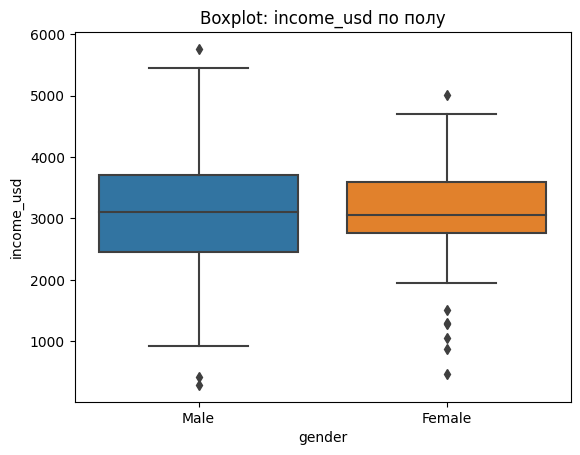

In [20]:
# Построй boxplot для income_usd по полу.

sns.boxplot(x='gender', y='income_usd', data=df_check)
plt.title('Boxplot: income_usd по полу')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


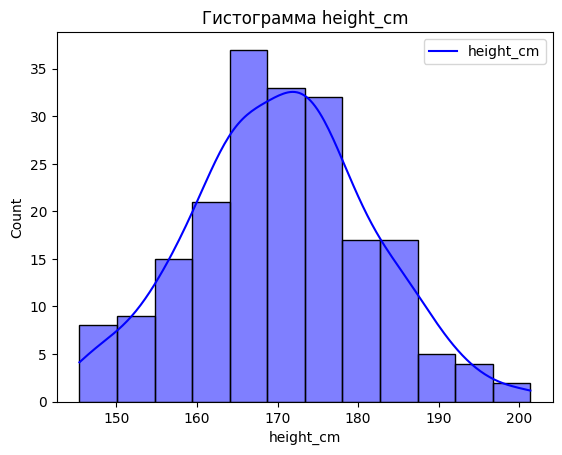

In [21]:
# Построй гистограмму роста (height_cm) с KDE.

sns.histplot(df_check['height_cm'], kde=True, color='blue')
plt.legend(['height_cm'])
plt.title('Гистограмма height_cm')
plt.show()

<Axes: title={'center': 'Число регистрации пользователей по месяцам'}, xlabel='Месяц'>

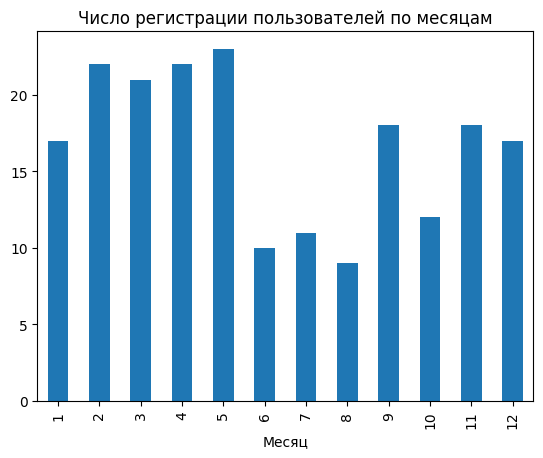

In [22]:
# Построй график числа регистраций по месяцам.

df_check.groupby(df_check['signup_date'].dt.month)['user_id'].nunique().plot(kind='bar', title='Число регистрации пользователей по месяцам', xlabel='Месяц')

# 9. Проверка гипотез

- Проверь гипотезу: средний рост мужчин больше, чем у женщин.

- Проверь гипотезу: средний доход отличается между премиум и непремиум пользователями.

- Проверь гипотезу: средний балл (score) отличается у пользователей из разных стран.

## Проверь гипотезу: средний рост мужчин больше, чем у женщин.

#### Гипотеза:

- H₀: Средний рост мужчин по сравнению со средним ростом женщин не изменился

- H₁: Средний рост мужчин больше по сравнению со средним ростом женщин

In [23]:
# Проверяем на наличие выбросов по значениям mean и 50%
df_check['height_cm'].describe()

count    200.000000
mean     170.402500
std       10.978483
min      145.400000
25%      163.375000
50%      171.050000
75%      177.525000
max      201.400000
Name: height_cm, dtype: float64

In [24]:
# Группируем необходимы данные для гипотезы

height_male = df_check[df_check['gender'] == 'Male']['height_cm']
height_female = df_check[df_check['gender'] == 'Female']['height_cm']

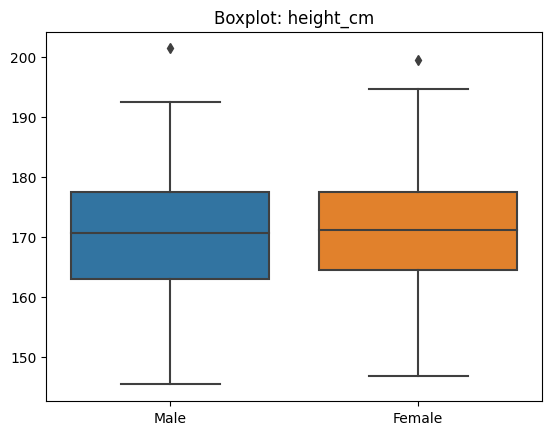

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


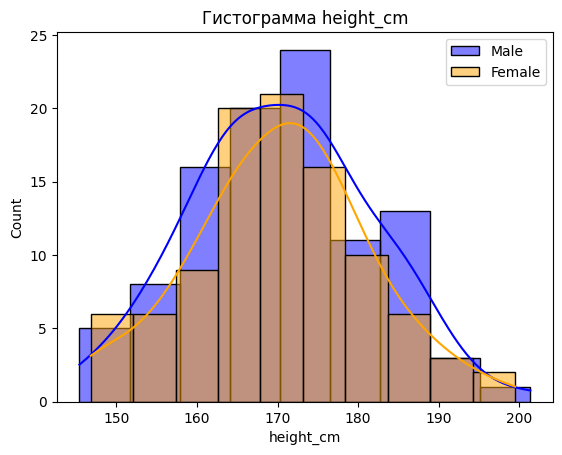

In [25]:
# Создаем boxplot и гистограмму для определения направления и выбросов

sns.boxplot(data=[height_male, height_female])
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.title('Boxplot: height_cm')
plt.show()


# Histplot + KDE
sns.histplot(height_male, kde=True, label='Male', color='blue')
sns.histplot(height_female, kde=True, label='Female', color='orange')
plt.legend()
plt.title('Гистограмма height_cm')
plt.show()


In [26]:
# Проверка нормальности

print("\n--- Проверка нормальности (Shapiro-Wilk) ---")
stat_m, p_m = shapiro(height_male)
stat_f, p_f = shapiro(height_female)
print(f"Male: p-value = {p_m:.5f} → ", "Нормальное распределение" if p_m > 0.05 else "Не нормальное распределение")
print(f"Female: p-value = {p_f:.5f} → ", "Нормальное распределение" if p_f > 0.05 else "Не нормальное распределение")


--- Проверка нормальности (Shapiro-Wilk) ---
Male: p-value = 0.96845 →  Нормальное распределение
Female: p-value = 0.75474 →  Нормальное распределение


In [27]:
# Проверка равенства дисперсий (Levene)

stat, p = levene(height_male, height_female)

print("\n--- Проверка равенства дисперсий (Levene) ---")
print(f"p-value = {p:.5f} → ", "Дисперсии равны" if p > 0.05 else "Дисперсии различаются")


--- Проверка равенства дисперсий (Levene) ---
p-value = 0.55824 →  Дисперсии равны


In [28]:
print("\n--- Статистический тест ---")
alpha = 0.05  # уровень значимости

if p_m > 0.05 and p_f > 0.05:
    # Нормальное распределение → t-test
    stat, p_value = ttest_ind(height_male, height_female, equal_var=True, alternative='greater')
    test_name = "t-test"
else:
    # Не нормальное распределение → Mann-Whitney U
    stat, p_value = mannwhitneyu(height_male, height_female, alternative='two-sided')
    test_name = "Mann-Whitney U"

# Вывод результатов
print(f"{test_name}: p-value = {p_value:.5f}")

# Интерпретация результата
if p_value < alpha:
    print("📌 Отклоняем H₀ — принимаем альтернативную гипотезу (есть статистически значимые различия)")
else:
    print("📌 Нет оснований отклонить H₀ (статистически значимые различия не обнаружены)")



--- Статистический тест ---
t-test: p-value = 0.48491
📌 Нет оснований отклонить H₀ (статистически значимые различия не обнаружены)


## Проверь гипотезу: средний доход отличается между премиум и непремиум пользователями.

#### Гипотеза
- H₀: Средний доход между премиум и непремиум пользователями не изменился

- H₁: Доход между пользователями премиум и непремиум изменился


In [29]:
is_premium_true = df_check[df_check['is_premium'] == True]['income_usd']
is_premium_false = df_check[df_check['is_premium'] == False]['income_usd']

In [30]:
df_check['income_usd'].describe()

count     200.000000
mean     3073.404975
std       918.415428
min       287.510000
25%      2638.677500
50%      3074.635000
75%      3668.702500
max      5760.760000
Name: income_usd, dtype: float64

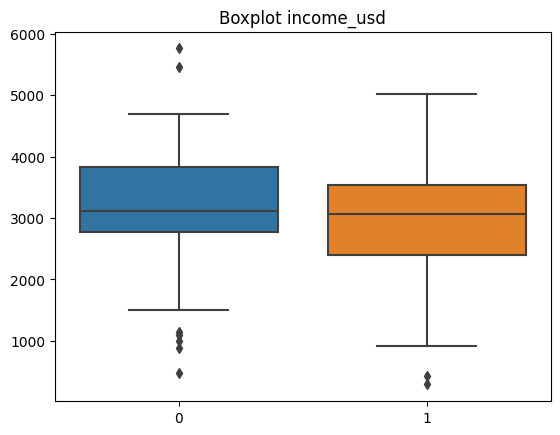

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


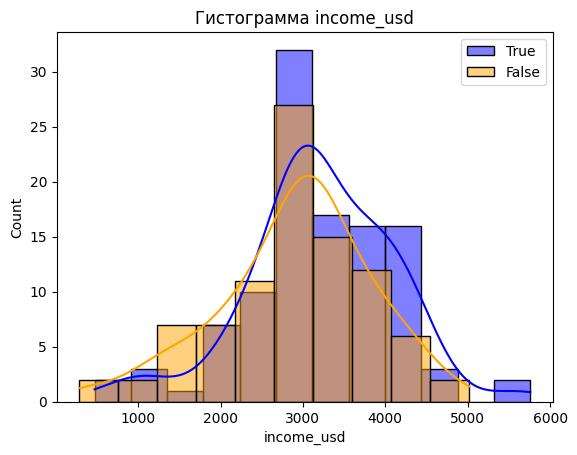

In [31]:
# Boxplot (выбросы)
sns.boxplot(data = [is_premium_true, is_premium_false])
plt.xticks = ([0,1], [True, False])
plt.title('Boxplot income_usd')
plt.show()

# Гистограмма

sns.histplot(is_premium_true, kde=True, label='True', color='blue')
sns.histplot(is_premium_false, kde=True, label='False', color='orange')
plt.legend()
plt.title('Гистограмма income_usd')
plt.show()

In [32]:
# Проверка нормальности

print("\n--- Проверка нормальности (Shapiro-Wilk) ---")
stat_m, p_m = shapiro(is_premium_true)
stat_f, p_f = shapiro(is_premium_false)
print(f"Male: p-value = {p_m:.5f} → ", "Нормальное распределение" if p_m > 0.05 else "Не нормальное распределение")
print(f"Female: p-value = {p_f:.5f} → ", "Нормальное распределение" if p_f > 0.05 else "Не нормальное распределение")


--- Проверка нормальности (Shapiro-Wilk) ---
Male: p-value = 0.02789 →  Не нормальное распределение
Female: p-value = 0.09239 →  Нормальное распределение


In [33]:
# Проверка равенства дисперсий (Levene)

stat, p = levene(is_premium_true, is_premium_false)
print(f"Levene test p-value = {p}")

print("\n--- Проверка равенства дисперсий (Levene) ---")
print(f"p-value = {p:.5f} → ", "Дисперсии равны" if p > 0.05 else "Дисперсии различаются")

Levene test p-value = 0.8163752906777814

--- Проверка равенства дисперсий (Levene) ---
p-value = 0.81638 →  Дисперсии равны


In [34]:
print("\n--- Статистический тест ---")
alpha = 0.05  # уровень значимости

if p_m > 0.05 and p_f > 0.05:
    # Нормальное распределение → t-test
    stat, p_value = ttest_ind(is_premium_true, is_premium_false, equal_var=False, alternative='greater')
    test_name = "t-test"
else:
    # Не нормальное распределение → Mann-Whitney U
    stat, p_value = mannwhitneyu(is_premium_true, is_premium_false, alternative='two-sided')
    test_name = "Mann-Whitney U"

# Вывод результатов
print(f"{test_name}: p-value = {p_value:.5f}")

# Интерпретация результата
if p_value < alpha:
    print("📌 Отклоняем H₀ — принимаем альтернативную гипотезу (есть статистически значимые различия)")
else:
    print("📌 Нет оснований отклонить H₀ (статистически значимые различия не обнаружены)")


--- Статистический тест ---
Mann-Whitney U: p-value = 0.03465
📌 Отклоняем H₀ — принимаем альтернативную гипотезу (есть статистически значимые различия)


## Проверь гипотезу: средний балл (score) отличается у пользователей из разных стран.

#### Гипотеза

- H₀: Средний балл между пользователей из разных стран не изменился

- H₁: Средний балл между пользователями из разных стран изменился

In [35]:
# Проверка нормальности распределения

print("🧪 Проверка нормальности распределения (Shapiro–Wilk):")
normal_flags = []
for country in sorted(df_check['country'].unique()):
    stat, p = shapiro(df_check[df_check['country'] == country]['score'])
    is_normal = p > 0.05
    normal_flags.append(is_normal)
    print(f"{country}: p-value = {p:.5f} → {'нормальное распределение' if is_normal else 'ненормальное распределение'}")

🧪 Проверка нормальности распределения (Shapiro–Wilk):
Canada: p-value = 0.11033 → нормальное распределение
France: p-value = 0.04219 → ненормальное распределение
Germany: p-value = 0.03958 → ненормальное распределение
UK: p-value = 0.03938 → ненормальное распределение
USA: p-value = 0.00086 → ненормальное распределение


In [36]:
# Проверка гомогенности дисперсий

print("\n📊 Проверка гомогенности дисперсий (Levene test):")
grouped = [df_check[df_check['country'] == c]['score'] for c in df_check['country'].unique()]
stat_lev, p_lev = levene(*grouped)
equal_var = p_lev > 0.05
print(f"Levene test: p-value = {p_lev:.5f} → {'дисперсии можно считать равными' if equal_var else 'дисперсии можно считать не равными'}")


📊 Проверка гомогенности дисперсий (Levene test):
Levene test: p-value = 0.88257 → дисперсии можно считать равными


In [37]:
# Выбор теста

print("\n🔬 Статистический тест:")

alpha = 0.05

if all(normal_flags) and equal_var:
    stat_anova, p_anova = f_oneway(*grouped)
    print(f"ANOVA: p-value = {p_anova:.5f} → ", end='')
    if p_anova <= alpha:
        print("Отклоняем H₀ — есть статистически значимые различия между странами")
    else:
        print("Нет оснований отклонить H₀ — различия между странами не значимы")
else:
    stat_kruskal, p_kruskal = kruskal(*grouped)
    print(f"Kruskal–Wallis: p-value = {p_kruskal:.5f} → ", end='')
    if p_kruskal <= alpha:
        print("Отклоняем H₀ — есть статистически значимые различия между странами")
    else:
        print("Нет оснований отклонить H₀ — различия между странами не значимы")


🔬 Статистический тест:
Kruskal–Wallis: p-value = 0.03926 → Отклоняем H₀ — есть статистически значимые различия между странами
